In [76]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
# modèle
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
df = pd.read_csv('BD/P2_G5_films.csv.gz', compression = 'gzip', na_values = ['\\N'])


In [78]:
df = df.sample(500)

In [80]:
# CHOIX DES CARACTERISTIQUES

colonnes = df.columns
caracteristiques = []

for element in colonnes:
    if 'out_KNN' not in element:
        caracteristiques.append(element)

In [81]:
# df_LN = df[df['vote_count_mean'] != 0].drop(['adult', 'production_countries', 'status', 'tagline', 'production_companies_name', 'production_companies_country', 'titleType', 'region', 'Decennie', 'genre', 'final_language', 'popularity', 'year_exact', 'runtime_exact', 'vote_exact', 'arrondi_vote_exact', 'vote_count_mean'], axis = 1)
# df_LN_drop_NA = df_LN.dropna()
# X = df_LN_drop_NA
# y = pd.DataFrame(df_LN_drop_NA)

# def encodage_X(X, type='standard'):
#   X_num = X.select_dtypes('number')
#   X_cat = X.select_dtypes(['object', 'category', 'string'])
#   # Comme ça les dates, on n'y touche pas

#   if type == 'standard':
#     from sklearn.preprocessing import StandardScaler
#     SN = StandardScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   else:
#     from sklearn.preprocessing import MinMaxScaler
#     SN = MinMaxScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   X_cat_dummies = pd.get_dummies(X_cat)
#   X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   return X_encoded, SN

# X_encoded, SN = encodage_X(X)

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8)

# from sklearn.linear_model import LinearRegression

# modele = LinearRegression()

# modele.fit(X_train, y_train)

# print(f"Score d'entrainement {modele.score(X_train, y_train)}")
# print(f"Score de test {modele.score(X_test, y_test)}")

# df_a_predire = df_test[df_test['vote_count_mean'] == 0].drop(['isOriginalTitle', 'ordering', 'film_id', 'id', 'revenue', 'budget', 'backdrop_path', 'homepage', 'overview', 'poster_path', 'status', 'tagline', 'video', 'titleType', 'types', 'attributes'], axis = 1)
# df_a_predire = df_a_predire.drap('vote_count_mean', axis = 1)
# df_quelonveutpredire = df_a_predire.dropna()

# def encodage_predict(df_a_predire):
#   X_num = df_a_predire.select_dtypes('number')
#   X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

#   X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

#   X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
#   X_encoded_predire = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   df_predict = X_encoded_predire

#   # DataFrame vide qui a les mêmes colonnes que X_encoded
#   df_final = pd.DataFrame(columns=X_encoded.columns)

#   # On veut que le DataFrame ait le même nombre de lignes que df_predict
#   df_final = df_final.reindex(index=df_predict.index)
#   # On met tous les NaN à False
#   df_final = df_final.fillna(False)

#   # On parcourt chaque colonne de df_predict
#   # Si la colonne est présente dans X_encoded alors on la garde
#   # Sinon, on la met à False
#   for column in df_predict.columns:
#     if column in X_encoded.columns:
#       df_final[column] = df_predict[column]

#   return df_final

# df_pour_prediction = encodage_predict(df_quelonveutpredire)

# df_quelonveutpredire['prediction'] = modele.predict(df_pour_prediction)
# df_quelonveutpredire


FONCTION JONATHAN

FONCTIONS

In [82]:
# METTRE UNIQUEMENT POUR LES COLONNES NUMERIQUES

poids_list = pd.DataFrame(columns = df.select_dtypes(include = 'number').columns, index = ['poids'])

poids = {
 'popularity' : 10,
 'year_exact' : 10,
 'runtime_exact' : 10,
 'vote_exact' : 10,
 'arrondi_vote_exact' : 10,
 'vote_count_mean' : 10,
 'prod_US' : 10,
 'prod_FR' : 10
}

for element in poids_list.columns:
    if element in poids.keys():
        poids_list[element].iloc[0] = poids[element]
    else:
        poids_list[element].iloc[0] = 1

In [83]:
# FONCTION 1

def encodage_X(X, type='standard'):
  from sklearn.preprocessing import StandardScaler
  index = X.index
  X_num = X.select_dtypes('number')
  X_cat = X.select_dtypes(['object', 'category', 'string'])

  if type == 'standard':
    from sklearn.preprocessing import StandardScaler
    SN = StandardScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

  else:
    from sklearn.preprocessing import MinMaxScaler
    SN = MinMaxScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

  X_num_SN = X_num_SN.mul(poids, axis = 1)
  X_cat_dummies = pd.get_dummies(X_cat)
  X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

  return X_encoded, SN, X_num_SN, X_cat_dummies

# FONCTION 2

def evaluate_k(X_encoded, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        X_encoded (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Calcul des distances moyennes pour chaque k
        from sklearn.neighbors import NearestNeighbors
        model = NearestNeighbors(n_neighbors=k)
        model.fit(X_encoded)
        distances, _ = model.kneighbors(X_encoded)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        # Nous utilisons KMeans pour créer des clusters et évaluer la qualité
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_encoded)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(X_encoded, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

# FONCTION 3

def encodage_predict(df_a_predire):
  X_num = df_a_predire.select_dtypes('number')
  X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

  X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

  X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
  X_encoded_predire = pd.concat([X_num_SN, X_cat_dummies], axis=1)

  df_predict = X_encoded_predire

  # DataFrame vide qui a les mêmes colonnes que X_encoded
  df_final = pd.DataFrame(columns=X_encoded.columns)

  # On veut que le DataFrame ait le même nombre de lignes que df_predict
  df_final = df_final.reindex(index=df_predict.index)
  # On met tous les NaN à False
  df_final = df_final.fillna(False)

  # On parcourt chaque colonne de df_predict
  # Si la colonne est présente dans X_encoded alors on la garde
  # Sinon, on la met à False
  for column in df_predict.columns:
    if column in X_encoded.columns:
      df_final[column] = df_predict[column]

  return df_final

# FONCTION 4

def pokemons_similaires(film_id):

  # Vérifier si le Pokémon existe dans le dataset
  if film_id not in df['film_id_out_KNN'].values:
      return f"Le Pokémon {film_id} n'est pas dans le dataset."

  # Récupérer les caractéristiques du Pokémon
  pokemon = df[df['film_id_out_KNN'] == film_id]

  # Je recopie ce qu'on a fait avant:
  caract_pokemon = df[df['film_id_out_KNN'] == film_id][caracteristiques]

  caract_pokemon_encoded = encodage_predict(caract_pokemon)

  distances, indices = model.kneighbors(caract_pokemon_encoded)

  return df.iloc[indices[0]].reset_index(drop=True)

In [84]:
# BASES

X = df[caracteristiques]
recherche = 'Star Wars'
df[df['title_out_KNN'].str.contains(recherche) == True]

film_id = df['film_id_out_KNN'][df['title_out_KNN'].str.contains(recherche) == True].iloc[0]
df_a_predire = df[df['film_id_out_KNN'] == film_id]


# FONCTION 1

X_encoded, SN, X_num_SN, X_cat_dummies = encodage_X(X)

# FONCTION 2

k_range = range(1, 5) 
avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# FONCTION 3

df_final = encodage_predict(df_a_predire)

# FONCTION 4
# On choisit k
k=3

model = NearestNeighbors(n_neighbors=k, metric='euclidean')
model.fit(X_encoded)
pokemons_similaires(film_id)

In [8]:
pokemons_similaires(film_id)['title_out_KNN']

0        Cyclone of the Saddle
1     Three Sailors and a Girl
2    Raiders of the Seven Seas
Name: title_out_KNN, dtype: object

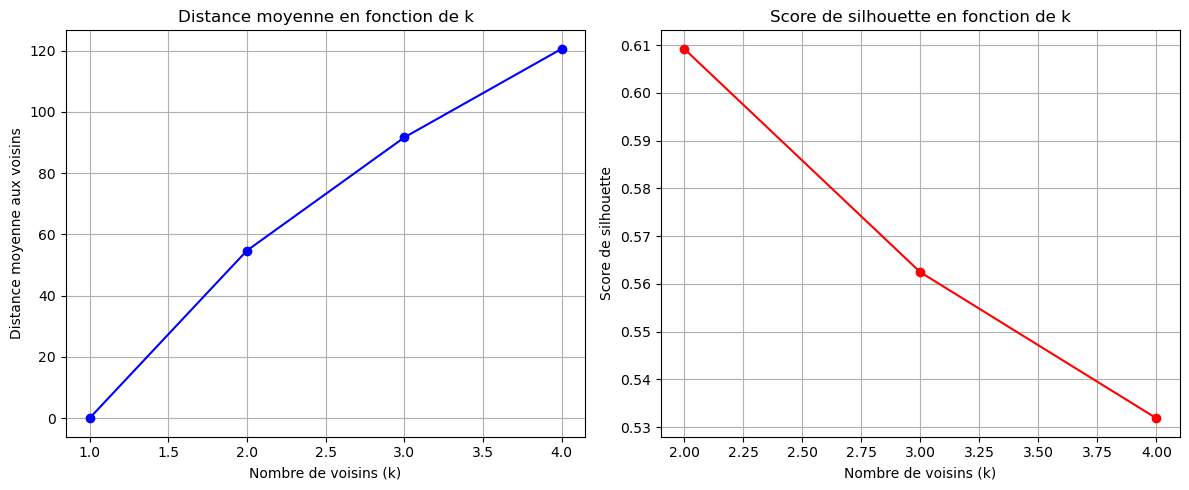

In [10]:
# Définition de la plage de k à tester


# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()